Import simulator and utilities

In [46]:
from Tfdtd.fdtd import FDTD2D
from Tfdtd.utilities import print_setup_info
from Tfdtd.detectors import PointDetector
from Tfdtd.sources import PointSource, LineSource

from Tfdtd.geometries import Rectangle, Circle

from Tfdtd.viz import viz2D

### Simulation parameters

###### Geometry parameters

In [47]:
eps = 13          # dielectric constant of waveguide
w = 1.2e-6           # width of waveguide
r = 0.36e-6          # radius of holes
d = 1.4e-6           # defect spacing (ordinary spacing = 1)
N = 3             # number of holes on either side of defect

In [48]:
print('nx',16e-6/50e-9)
print('ny',8e-6/50e-9)
print('w',w/50e-9)
print('r',0.36e-6/50e-9) 
print('d',d/50e-9)
print('ordinary spacing',1e-6/50e-9)

nx 320.0
ny 160.0
w 24.0
r 7.2
d 28.0
ordinary spacing 20.0


In [49]:
params = {
    'backend': 'pytorch',
    'precision': 'float64',
    'nx': 320,
    'ny': 160,
    'time_steps': 10000,
    'dx': 50e-9,
    'dy': 50e-9,
    'polarization': 'TE',
    'use_pml': True,
    'pml_thickness': 20,
}

### Testing initializations

In [59]:
sim = FDTD2D(params = params)

Reading configuration from dictionary...


### Set geometry

In [60]:
rectangle = Rectangle(x1=0, y1=68, x2=sim.nx, y2=92, epsr=eps, sigma=0)
sim.add_geometry(rectangle)
sim.update_geometry()

In [61]:
for i in range(0, N):
    circle = Circle(center_x=106+i*20, center_y=80, radius=7.2, epsr=1, sigma=0)
    sim.add_geometry(circle)
    sim.update_geometry()

for i in range(0, N):
    circle = Circle(center_x=174+i*20, center_y=80, radius=7.2, epsr=1, sigma=0)
    sim.add_geometry(circle)
    sim.update_geometry()

### Set sources

In [62]:
# Conversion from meep to real units
import numpy as np
f_meep  = 0.235 # frequency in meep
c = 2.99e8 # speed of light
a = 1e-6 # Characteristic lenght of the structure
f_real = f_meep * c /a # frequency in real units

print(np.format_float_scientific((f_real), unique=False, precision=2))
#print('speed of light in material',c / np.sqrt(12))

7.03e+13


### Point source

In [21]:
source_params_gaussian = {
    'source_type': 'point_source',  # Add 'source_type' key
    'function': 'gaussian_pulse',
    'source_x': 40,
    'source_y': 80,
    'amplitude': 1.0,
    't0': 0, # t0 is expressed in unit of time not time steps
    'frequency_center': 0.7e14,
    'frequency_width': 0.1e14
}

# source_params_sinusoidal = {
#     'source_type': 'point_source',  # Add 'source_type' key
#     'function': 'sinusoidal',
#     'source_x': 158,
#     'source_y': 82,
#     'frequency': 0.7e14
# }

gaussian_source = PointSource(source_params_gaussian)
#sinusoidal_source = PointSource(source_params_sinusoidal)

### Line source

In [63]:
source_params_gaussian = {
    'source_type': 'line_source',  # Add 'source_type' key
    'function': 'gaussian_pulse',
    'x': 40,
    'y1': 70,
    'y2': 90,
    'amplitude': 1.0,
    't0': 10,
    'spread': 0.3
}

source_params_sinusoidal = {
    'source_type': 'line_source',  # Add 'source_type' key
    'function': 'sinusoidal',
    'x': 40,
    'y1': 70,
    'y2': 90,
    'frequency': 0.5e14
}

#gaussian_source = LineSource(source_params_gaussian)
sinusoidal_source = LineSource(source_params_sinusoidal)


In [64]:
sim.add_source(sinusoidal_source)

### Add a detector

In [65]:
detector_params = {
    'name': 'detector1',
    'position': (300, 85),
}
point_detector = PointDetector(detector_params)
sim.add_detector(point_detector)

### Print simulation info

In [66]:
print_setup_info(sim)

Simulation setup information:
nx: 320
ny: 160
time_steps: 10000
dx: 5e-08
dy: 5e-08
dt: 1.179327168374842e-16
use_pml: True
pml_thickness: 20
c: 299792458
epsilon_0: 8.85418782e-12
mu_0: 1.25663706e-06
Source 0: source_type: line_source, function: sinusoidal, x: 40, y1: 70, y2: 90, frequency: 50000000000000.0, omega: 314159265358979.3
Detector 0: Detector: detector1, Position: (300, 85)


### Show material distribution

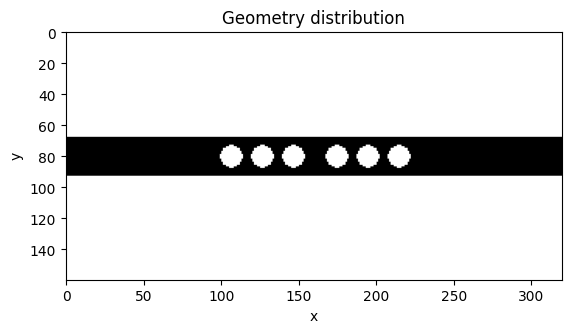

In [67]:
# Visualize permittivity distribution
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np.transpose(sim.eps_r), cmap='binary')
plt.title('Geometry distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Simulate

In [68]:
for i in range(1, sim.time_steps):
    sim.simulation_step(i)
    sim.record_detectors(sim.h_field[:,:,2])

### Visualize fields

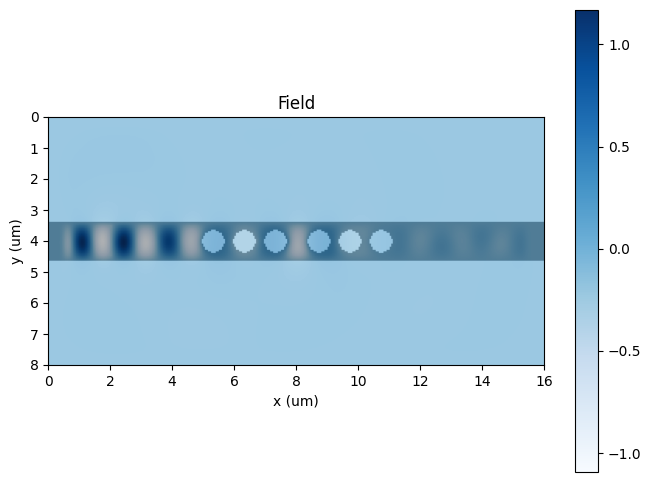

In [72]:
viz2D(sim, sim.h_field[:,:,2])

### Visualize detector

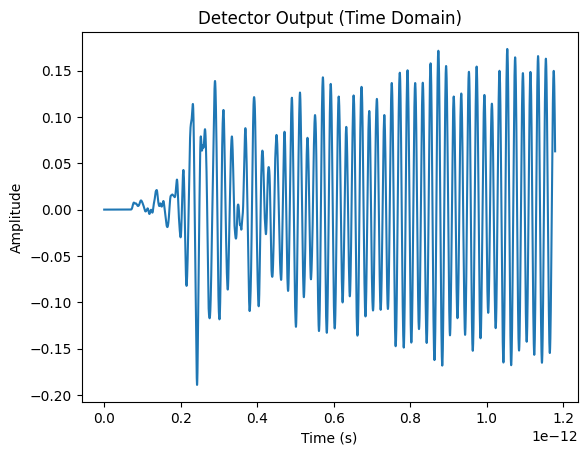

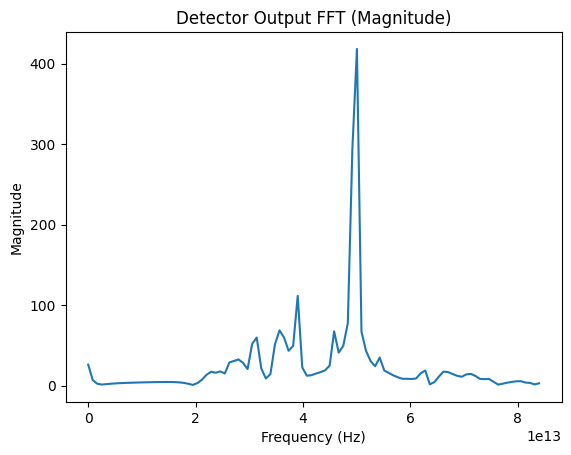

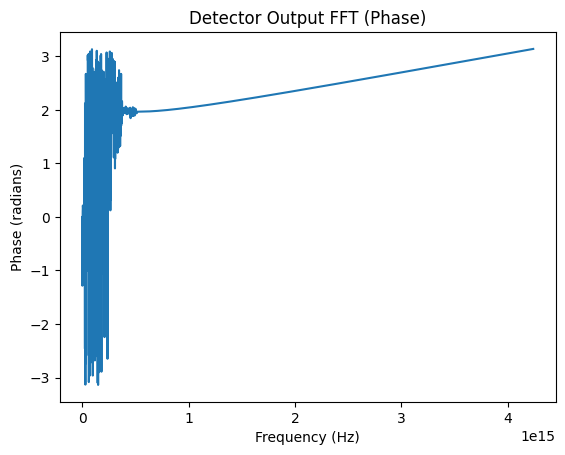

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Define simulation parameters
time_steps = 9999
dt = 1.179327168374842e-16

# Create a simple FDTD detector output (replace this with your actual detector data)
t = np.arange(0, time_steps * dt, dt)
# f0 = 3e9
# sigma_t = 1 / (2 * np.pi * f0)
# t0 = 5 * sigma_t
# A = 1
# detector_output = A * np.exp(-(t - t0)**2 / (2 * sigma_t**2)) * np.cos(2 * np.pi * f0 * (t - t0))
detector_output = np.stack([t.numpy() for t in point_detector.recorded_values]).squeeze()

# Compute the Fourier Transform of the detector output
detector_fft = np.fft.fft(detector_output)
freqs = np.fft.fftfreq(time_steps, dt)

# Calculate the magnitude and phase of the Fourier Transform
magnitude = np.abs(detector_fft)
phase = np.angle(detector_fft)

# Plot the time-domain detector output
plt.figure()
plt.plot(t, detector_output)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Detector Output (Time Domain)')

# Plot the magnitude of the Fourier Transform
plt.figure()
plt.plot(freqs[:time_steps//2][0:100], magnitude[:time_steps//2][0:100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Detector Output FFT (Magnitude)')

# Plot the phase of the Fourier Transform
plt.figure()
plt.plot(freqs[:time_steps//2], phase[:time_steps//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.title('Detector Output FFT (Phase)')

plt.show()